## <h1 align="center">Aprendendo Machine learning com classificação semi supervisionada - Dataset "Credit Card Fraud Detection"</h1>

Vamos utilizar um aprendizado semi supervisionado, de forma que os dados "unlabelled" é usado no modelo de treino também, assim as propriedades de um aprendizado não supervisionado serão usadas para aprender a melhor representação dos dados possível para fazer um aprendizado supervisionado, permitindo que utilizemos um modelo de previsão.

Como realizar a classificação com aprendizado semi supervisionado:

Vamos usar Autoencoders para aprender a representação dos dados e aí sim utilizar um modelo linear para dividir as classes.

<h1 align="center">Sobre o Dataset - Credit Card Fraud Detection</h1>  

Utilizaremos o Dataset [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) by ULB machine learning group.

Descrição disponível no Kaggle:

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 



### Conteúdo

1. Preparando o Dataset  
2. Visualizando Fraude Vs Não Fraude, algoritmo T-SNE  
3. AutoEncoders
4. Obtendo as Representações Latentes  
5. Visualizar a Representação Latente: Fraude VS Não Fraude  
6. Classificação Linear Simples  
 
## 1. Preparando o Dataset

Vamos carregar as bibliotecas necessárias:
 



In [24]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("../input/creditcardfraud/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Este dataset possui 28 variáveis anônimas, uma variável de quantidade "Amount", uma variável de tempo "time" e 1 variável que é nosso target, denominada "Class". Vamos ver a distribuição da nossa variável target:

0 = Não Fraude

1 = Fraude

In [25]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


Verificamos um grande problema: a nossa variável Target não está balanceada, apenas 0.17% dos casos são fraudes.

Vamos verificar a natureza dessas ações usando o algoritmo t-SNE

A idéia final de se realizar uma representação linear nos ajuda com este problema! Vamos ver se conseguiremos fazer isso mais para frente:


## Vamos utilizar apenas as 1.000 linhas de não-fraude.

In [26]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

## 2. Visualizando Fraudes e Não-fraudes - Algoritmo t-SNE

Vamos verificar a natureza das transações, classificando como fraude e não fraude usando o algoritmo T-SNE.(Incorporação estocástica de vizinhos ou t-Distributed Stochastic Neighbor Embedding)

Essa técnica reduz as dimensões dos dados e produz apenas os maiores N componentes com a máxima informação.

No gráfico abaixo, aplicamos o algoritmo T-SNE, cada ponto verde é uma transação não fraudulenta, já os pontos vermelhos são fraudes. 

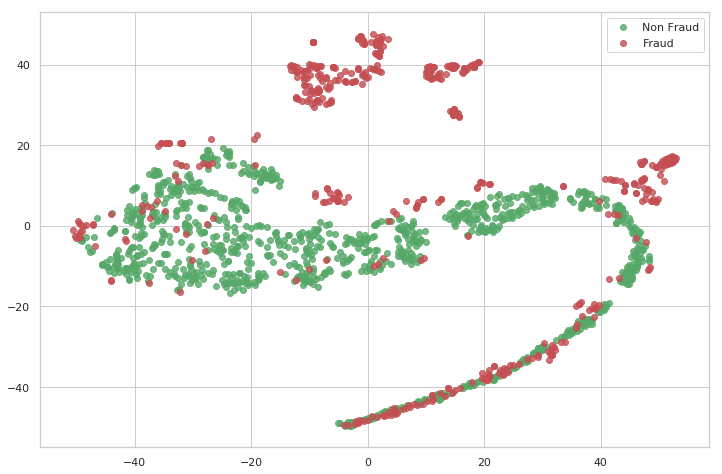

In [27]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

Já podemos observar que as fraudes estão muito próximas das não-fraudes, dessa forma, não conseguimos realizar uma classificação supervisionada. Desta forma, iremos utilizar a classificação não supervisionada, utilizando AutoEncoders.


## 3. AutoEncoders

Vamos criar um modelo de Autoencoder em que iremos mostrar apenas casos de não fraude. O modelo então irá tentar aprender a melhor representação possível da classe não fraude, dessa forma, o mesmo modelo vai ser utilizado para gerar representações de fraude, e esperamos que seja diferente do modelo não fraude. Vamos então utilizar um algoritmo que tenta prever o seu próprio input com as dimensões idênticas, após passar pela compressão. Depois procuraremos na Layer qual será a sua representação latente.

In [28]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Vamos criar a arquitetura do modelo através de compilar as layers de input com as de output. 

Vamos adicionar também uma função de otimização e de perca, vamos usar "adadelta" como função otimizador e "mse" como função perca.

In [29]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Antes de realizar o treino, vamos fazer a escala Min Max:

In [30]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

A vantagem desta abordagem é que não precisamos de muitas amostras para ter uma boa representação, vamos usar apenas 2.000 linhas de não fraude (isso equivale a apenas 0,7% da amostra não-fraude de 284.315) para treinar o autoencoder.

Uma vez que utilizamos essa metodologia, não precisamos também rodar este modelo com um grande número de Epochs!
(Vários Batches --> 1 Epoch)

Desta forma, ganharemos tempo de processamento. 

O intuíto de utilizar pequenas amostras é que precisamos dividir em duas classes: fraudes e não fraudes. Utilizando apenas em nossas amostras a característica não fraude, o Autoencoder irá distinguir características únicas que serão aplicadas nessa classe de amostras. Depois disso, o autoencoder irá tentar aprender apenas sobre uma classe e irá distingui-la da outra classe.

Após essa operação, ficará mais simples identificarmos padrões e aplicaremos uma metodologia supervisionada.

In [37]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 0s 21us/step - loss: 0.0800 - val_loss: 0.0709
Epoch 2/10
1600/1600 [==============================] - 0s 16us/step - loss: 0.0843 - val_loss: 0.0690
Epoch 3/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0771 - val_loss: 0.0666
Epoch 4/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0758 - val_loss: 0.0665
Epoch 5/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0763 - val_loss: 0.0667
Epoch 6/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0760 - val_loss: 0.0663
Epoch 7/10
1600/1600 [==============================] - 0s 16us/step - loss: 0.0744 - val_loss: 0.0668
Epoch 8/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0758 - val_loss: 0.0662
Epoch 9/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0751 - val_loss: 0.0660
Epoch 10/10
1600/1600 [===

## 4. Obtendo a Representação Latente

Agora o modelo está treinado. Estamos interessados em obter a *Representação Latente* do nosso input, aprendido pelo modelo!

Podemos descobri-la pelos pesos do modelo treinado. 

Vamos criar uma sequência de Layers em que poderemos adicionar os pesos treinados até a terceira camada, onde a representação latente está.


In [32]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Gerando as representações escondidas de duas classes: Fraude e Não fraude, por previsão de inputs usando o modelo acima.

In [38]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

## 5. Visualizando a Representação Latente: Fraude VS Não Fraude

Agora iremos criar um dataset de treino usando a representação latente obtida e vamos visualizar agora a natureza da classe Fraude VS Não-fraude.

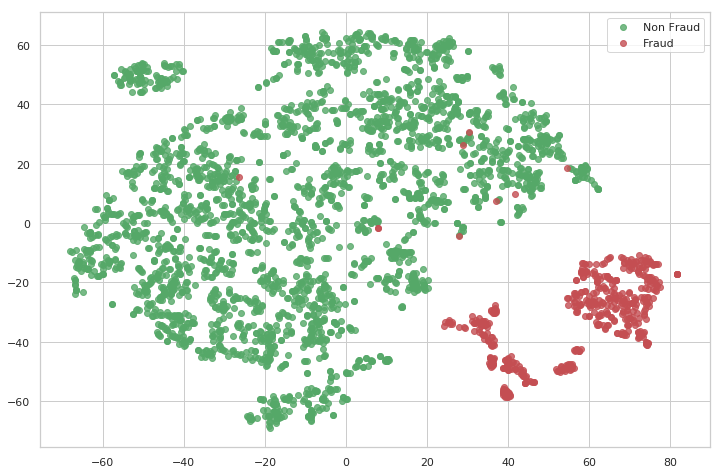

In [39]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

Conseguimos! Podemos observar que tanto as Fraudes quanto as Não Fraudes são bem visíveis e linearmente separadas. Desta forma, não precisaremos de nenhum modelo complexo para classificar isto. Um modelo linear ja é bastante suficiente para fazer as previsões necessárias.

In [40]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Representação Real (Antes) </b></td><td><b>Representação Latente (Depois)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

Representação Real (Antes),Representação Latente (Depois)
,


Agora vamos treinar um modelo simples de classificação linear no nosso dataset e verificar o resultado.

## 6. Classificador Linear Simples

In [41]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       741
         1.0       1.00      0.90      0.95       132

   micro avg       0.99      0.99      0.99       873
   macro avg       0.99      0.95      0.97       873
weighted avg       0.99      0.99      0.98       873


Accuracy Score:  0.9851088201603666


In [ ]:
Este é um resultado excepcional, a Acurácia do modelo está em 0.9851088201603666.
Me pergunto se o modelo está sofrendo com Overfitting.

Realizarei novos testes com outros algoritmos de ML e dependendo dos resultados, aplicar um SMOTE ou Adasyn para solucionar o problema com undersampling.